In [737]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [738]:
df = pd.read_csv('data/agg_prod_data.csv')


In [753]:
df[df['lvl_2_cat']=='Eyeliner']['unit_price'].mean()

1806.2215511008303

In [783]:
# df.loc[(df.product_name=='soleil brulant') & (df['amount_adj']==1.0)]['brand_name']#,'brand_name'].values[0]

# product_name
# brand_name

# unit price
# vol
# price
# rating
# product reviews
# sku


# data = df[(df['lvl_2_cat']=='Perfume') & (df['amount_adj']==1)]['unit_price'].hist(bins=50)
# & (df['unit_price']<310)].shape

In [791]:
df

,product_id,product_name,brand_name,swatch_group,amount_a,price,internal_product_id,rating,product_reviews,n_loves,lvl_0_cat,lvl_1_cat,lvl_2_cat,sku,amount_b,unit_b,product_multiplier,amount_adj,unit_price,prod_size_rank
0,1018539,master mattes™ liquid eyeliner,makeup by mario,standard size,0.04,33.0,1,3.8354,164.0,14500.0,Makeup,Eye,Eyeliner,['2389542'],1.2,ml,1.0,0.04,825.000000,156.0
1,1479545,pro longwear fluidline eyeliner,mac cosmetics,standard size,0.10,30.0,1,3.9024,41.0,700.0,Makeup,Eye,Eyeliner,['2091122' '2091114' '2091072'],3.0,g,1.0,0.10,300.000000,345.0
2,4546778,mineralize timecheck lotion,mac cosmetics,standard size,1.00,55.0,1,4.5000,6.0,734.0,Skincare,Moisturizers,Moisturizers,['2099588'],30.0,ml,1.0,1.00,55.000000,2445.0
3,4845668,strobe cream,mac cosmetics,standard size,1.70,47.0,1,4.3269,52.0,10500.0,Skincare,Moisturizers,Moisturizers,['2099505' '2099513'],50.0,ml,1.0,1.70,27.647059,3496.0
4,4879887,prep + prime highlighter,mac cosmetics,standard size,0.12,37.0,1,4.5714,21.0,2900.0,Makeup,Face,Highlighter,['2096923' '2096949' '2096931' '2096956'],3.6,ml,1.0,0.12,308.333333,482.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035,9866,a*men,mugler,standard size,1.70,85.0,1,4.6000,70.0,1500.0,Fragrance,Men,Cologne,['530030'],50.0,ml,1.0,1.70,50.000000,4264.0
7036,9889,photo finish smooth & blur oil-free foundation...,smashbox,mini size,0.34,19.5,1,4.3173,7500.0,240800.0,Makeup,Face,Face Primer,['2517787'],10.0,ml,1.0,0.34,57.352941,1771.0
7037,9889,photo finish smooth & blur oil-free foundation...,smashbox,standard size,1.00,52.0,1,4.3173,7500.0,240800.0,Makeup,Face,Face Primer,['1349968'],30.0,ml,1.0,1.00,52.000000,3135.0
7038,9889,photo finish smooth & blur oil-free foundation...,smashbox,value size,1.70,75.0,1,4.3173,7500.0,240800.0,Makeup,Face,Face Primer,['2322485'],50.0,ml,1.0,1.70,44.117647,4265.0


### Vis for all product options

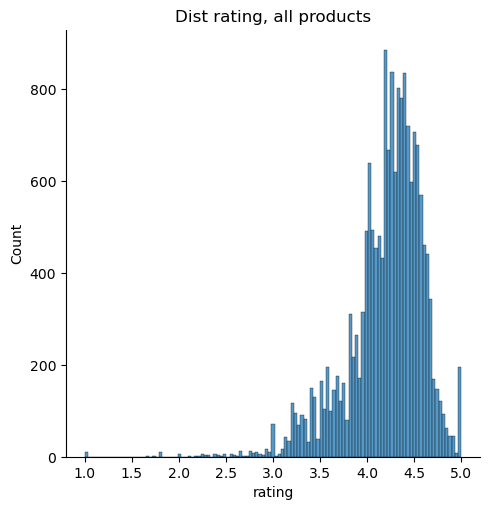

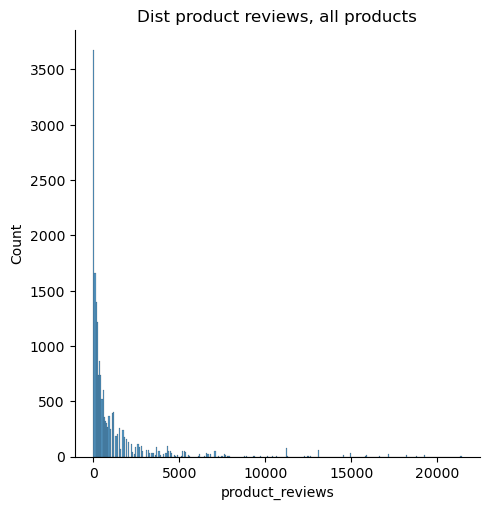

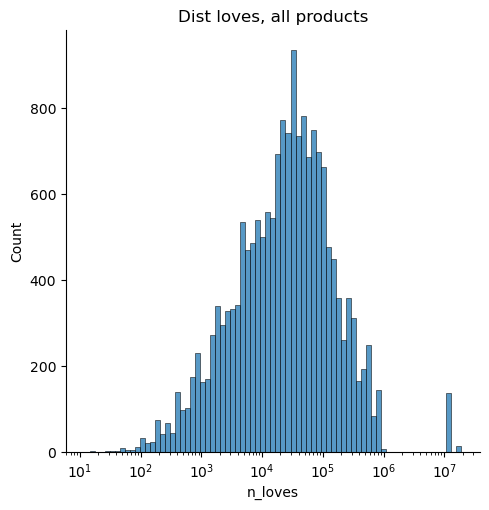

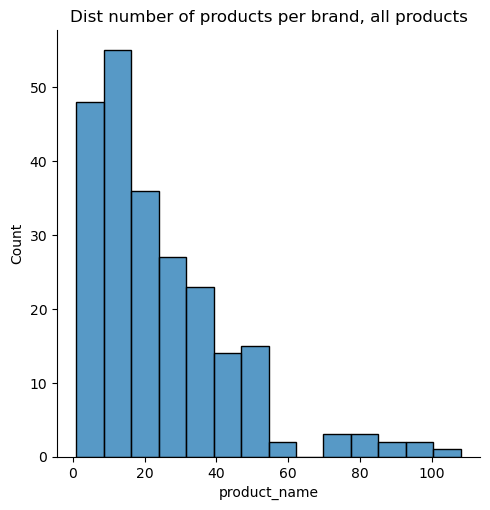

,brand_name,product_name
184,sephora collection,108
122,kérastase,98
24,bumble and bumble,93
209,tom ford,91
133,mac cosmetics,90


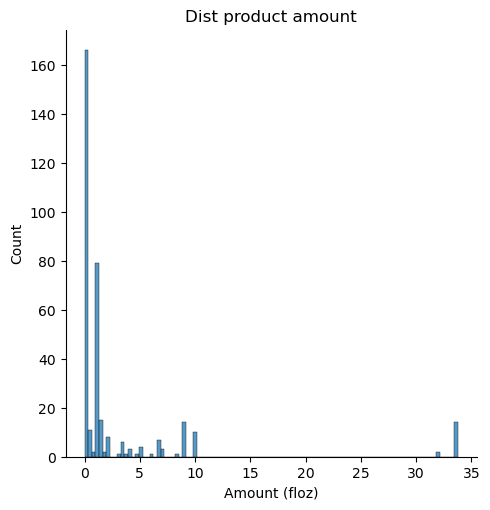

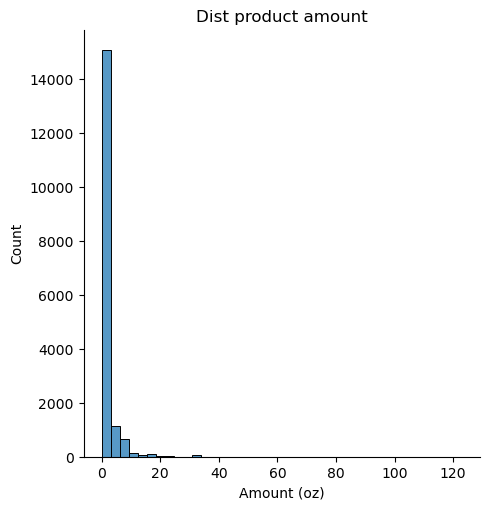

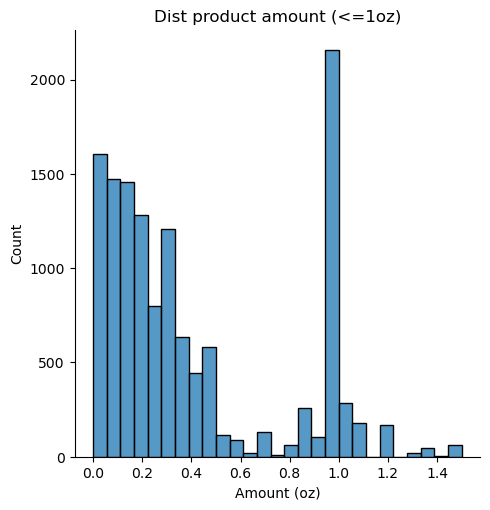

In [312]:

sns.displot(data=df_products, x="rating")
plt.title('Dist rating, all products')
plt.show()

sns.displot(data=df_products, x="product_reviews")#, log_scale=True)
plt.title('Dist product reviews, all products')
plt.show()

sns.displot(data=df_products, x="n_loves", log_scale=True)
plt.title('Dist loves, all products')
plt.show()

prods_per_brand = df_products.groupby('brand_name', as_index=False)['product_name'].nunique()
sns.displot(data=prods_per_brand, x="product_name")
plt.title('Dist number of products per brand, all products')
plt.show()
display(prods_per_brand.sort_values(by='product_name', ascending=False).head())

sns.displot(data=df_products[df_products['unit_a']=='floz'], x="amount_a")
plt.title('Dist product amount')
plt.xlabel('Amount (floz)')
plt.show()

sns.displot(data=df_products[df_products['unit_a']=='oz'], x="amount_a", bins=40)
plt.title('Dist product amount')
plt.xlabel('Amount (oz)')
plt.show()

sns.displot(data=df_products[(df_products['unit_a']=='oz') & (df_products['amount_a']<=1.5)], x="amount_a")
plt.title('Dist product amount (<=1oz)')
plt.xlabel('Amount (oz)')
plt.show()

# sns.displot(data=df_products[df_products['unit_a']=='floz'], x="unit_price",log_scale=True)
# plt.title('Dist unit price, floz products')
# plt.xlabel('log(Unit price) ($/floz)')
# plt.show()

# sns.displot(data=df_products, x="unit_price", log_scale=True)
# plt.title('Unit price distribution')
# plt.xlabel('log(Unit price ($/oz)) ')
# plt.tight_layout()
# plt.show()

In [683]:
df_products.groupby(['unit_a','unit_b'])['internal_product_id'].count()

unit_a  unit_b
floz    g             1
        ml          350
oz      g          5986
        kg            1
        l            15
        mg            1
        ml        11278
Name: internal_product_id, dtype: int64

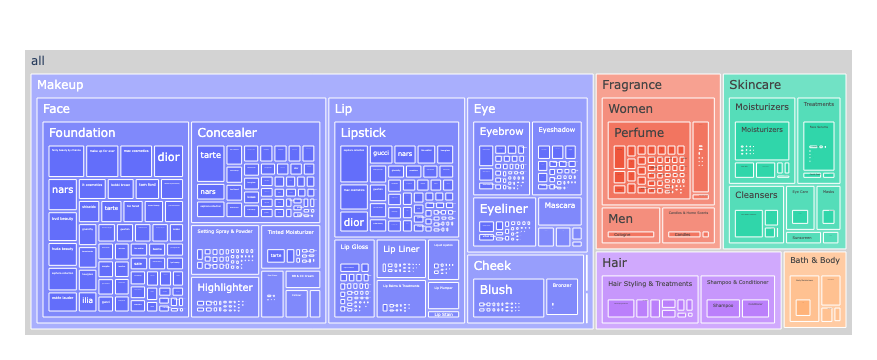

In [682]:

df_products_tree = df_products.groupby(['lvl_0_cat', 'lvl_1_cat', 'lvl_2_cat','brand_name'], as_index=False)['internal_product_id'].count()
fig = px.treemap(df_products_tree, path=[px.Constant("all"), 'lvl_0_cat', 'lvl_1_cat', 'lvl_2_cat','brand_name'], values='internal_product_id')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

# what is a single product ?

[brand_name, product_name, swatch_group, size, price]
 - if price is used and only some options are on sale, this would create duplicates
 - if price is left out of group-by, what is the best way to aggregate? max?
 
 - aggregated values like rating, product_reviews, n_loves should be same for all options of product?


https://www.sephora.com/ca/en/product/P434104?skuId=2407302

as each swatch group is clicked, sku in url changes
- a single product can have multiple skus depending on colour
- a single product can have multiple skus depending on size 


### Comparing standard with mini sizes

{426: 'hourglass-eyebrow',
 192: 'tom ford-perfume',
 514: 'givenchy-perfume',
 527: 'givenchy-perfume',
 600: 'too faced-lip plumper',
 710: 'strivectin-decollete & neck creams',
 117: 'dior-perfume',
 88: 'too faced-lip gloss',
 683: 'tarte-setting spray & powder',
 714: 'dior-perfume'}

,product_id,product_name,brand_name,swatch_group_mini,amount_a_mini,price_mini,internal_product_id_mini,rating_mini,product_reviews_mini,n_loves_mini,lvl_0_cat_mini,lvl_1_cat_mini,lvl_2_cat_mini,sku_mini,amount_b_mini,unit_b_mini,product_multiplier_mini,amount_adj_mini,unit_price_mini,prod_size_rank_mini,swatch_group_standard,amount_a_standard,price_standard,internal_product_id_standard,rating_standard,product_reviews_standard,n_loves_standard,lvl_0_cat_standard,lvl_1_cat_standard,lvl_2_cat_standard,sku_standard,amount_b_standard,unit_b_standard,product_multiplier_standard,amount_adj_standard,unit_price_standard,prod_size_rank_standard,mini_to_standard_ratio
117,385477,miss dior blooming bouquet,dior,mini size,0.7,55.0,1,4.3026,2500.0,129500.0,Fragrance,Women,Perfume,['2098044'],20.0,ml,1.0,0.7,78.571429,2334.0,standard size,1.0,100.0,1,4.3026,2500.0,129500.0,Fragrance,Women,Perfume,['2644516'],30.0,ml,1.0,1.0,100.000000,2491.0,0.785714
118,385477,miss dior blooming bouquet,dior,mini size,0.7,55.0,1,4.3026,2500.0,129500.0,Fragrance,Women,Perfume,['2098044'],20.0,ml,1.0,0.7,78.571429,2334.0,standard size,1.7,135.0,1,4.3026,2500.0,129500.0,Fragrance,Women,Perfume,['2644524'],50.0,ml,1.0,1.7,79.411765,3553.0,0.989418
119,385477,miss dior blooming bouquet,dior,mini size,0.7,55.0,1,4.3026,2500.0,129500.0,Fragrance,Women,Perfume,['2098044'],20.0,ml,1.0,0.7,78.571429,2334.0,standard size,3.4,180.0,1,4.3026,2500.0,129500.0,Fragrance,Women,Perfume,['2644532'],100.0,ml,1.0,3.4,52.941176,5083.0,1.484127
443,4484,hypnotic poison,dior,mini size,0.7,55.0,1,4.4199,936.0,75700.0,Fragrance,Women,Perfume,['2491462'],20.0,ml,1.0,0.7,78.571429,2340.0,standard size,1.0,95.0,1,4.4199,936.0,75700.0,Fragrance,Women,Perfume,['260893'],30.0,ml,1.0,1.0,95.000000,2704.0,0.827068
444,4484,hypnotic poison,dior,mini size,0.7,55.0,1,4.4199,936.0,75700.0,Fragrance,Women,Perfume,['2491462'],20.0,ml,1.0,0.7,78.571429,2340.0,standard size,1.7,125.0,1,4.4199,936.0,75700.0,Fragrance,Women,Perfume,['260885'],50.0,ml,1.0,1.7,73.529412,3807.0,1.068571


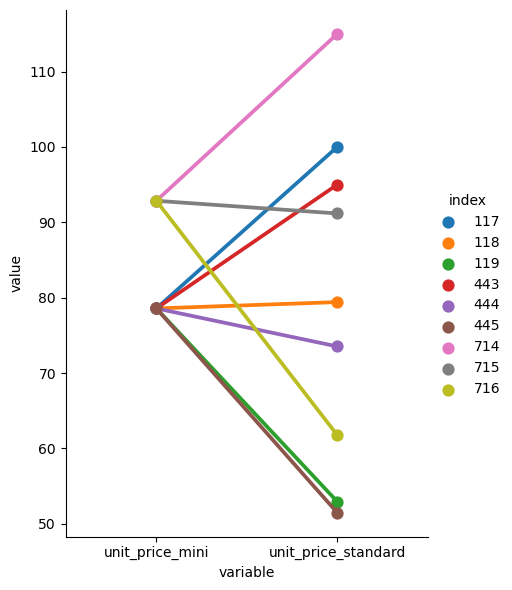

In [750]:
def filter_product_comparison_data(df, col, asc=True, lim=10):
    return df.sort_values(by=col, ascending=asc).head(lim)

# for each product, compare all mini size to standard using cross join
df_compare = df[df['swatch_group']=='mini size'].merge(
    df[df['swatch_group']=='standard size'],
    on=['product_id','product_name','brand_name'],
    suffixes=('_mini','_standard')
)
# only calculate ratio in one direction 
df_compare = df_compare[df_compare['amount_adj_mini']<df_compare['amount_adj_standard']]
# if ratio < 1, mini is better value per oz, if ratio > 1, standard is better value
df_compare['mini_to_standard_ratio'] = df_compare['unit_price_mini'] / df_compare['unit_price_standard']

# sort by ratio, best value mini
# df_compare = filter_product_comparison_data(df_compare, 'mini_to_standard_ratio', asc=True, lim=10)
# OR filter by brand 
df_compare = df_compare[df_compare['brand_name']=='dior']
display(df_compare.head())

df_compare = df_compare.reset_index()
df_compare = df_compare.melt(['product_id','brand_name','product_name','mini_to_standard_ratio',
                              'index','amount_adj_mini','amount_adj_standard'])

df_compare = df_compare[df_compare['variable'].isin(['unit_price_mini','unit_price_standard'])]
# df_compare = df_compare.merge(df, 
#                  on=['product_id','brand_name','product_name','amount_adj_mini','amount_adj_mini'],
#                  how='left')
# df_compare['display_name'] = df_compare['brand_name']+"-"+df_compare['lvl_2_cat'].str.lower()
# display(df_compare)

g = sns.catplot(
    data=df_compare, x="variable", y="value", hue="index",
    capsize=.2, #palette="YlGnBu_d",
    kind="point", height=6, aspect=.75,
)

In [736]:
df_compare.shape

(20, 9)

In [723]:
df_compare.shape

(20, 8)

In [591]:
df.sort_values(by='ranked_unit_price_ratio', ascending=True).head(5)

,product_id,product_name,brand_name,swatch_group,amount_a,price,internal_product_id,rating,product_reviews,n_loves,lvl_0_cat,lvl_1_cat,lvl_2_cat,sku,amount_b,unit_b,product_multiplier,amount_adj,unit_price,prod_size_rank,ranked_unit_price_ratio
6453,504163,sunday purifying clay detox shampoo,bumble and bumble,mini size,2.0000,17.0,1,4.7013,375.0,2500.0,Hair,Shampoo & Conditioner,Shampoo,[2653673],60.0,ml,1.0,2.0000,8.500000,4493.0,0.386364
60,12790,laguna talc-free bronzer powder,nars,mini size,0.0380,24.0,1,4.4119,369.0,170300.0,Makeup,Cheek,Bronzer,"[2670644, 2670651, 2670669, 2670677, 2670685]",3.5,g,1.0,0.0380,631.578947,152.0,0.480000
2654,447359,arch brow micro sculpting pencil,hourglass,mini size,0.0008,22.0,1,4.2364,588.0,18200.0,Makeup,Eye,Eyebrow,"[2303337, 2303345, 2303352]",0.2,g,1.0,0.0008,27500.000000,2.0,0.705128
1001,406527,soleil blanc shimmering body oil,tom ford,mini size,1.5000,42.0,1,4.3655,851.0,53800.0,Fragrance,Women,Perfume,[2327278],45.0,ml,1.0,1.5000,28.000000,3258.0,0.732308
3244,457669,l'interdit eau de parfum,givenchy,mini size,0.6700,51.0,1,4.3305,590.0,20400.0,Fragrance,Women,Perfume,[2353779],20.0,ml,1.0,0.6700,76.119403,2295.0,0.768177


In [667]:
# testing outer join to compare all size options for a product
test = pd.DataFrame({
    'pid':[1,1,1,1],
    'swatch_group':['mini','mini','full','full'],
    'unit_price':[10,12,22,24],
    'amount_adj':[1,1.7,3,3.5],
    'rank':[1,2,3,4]
})
test = test[test['swatch_group']=='mini'].merge(test[test['swatch_group']=='full'], on='pid')
test = test[test['amount_adj_x']<test['amount_adj_y']]
test['x_y_ratio'] = test['unit_price_x'] / test['unit_price_y']
# # but what if the input is dg light blue
# display(test)


In [668]:
test

,pid,swatch_group_x,unit_price_x,amount_adj_x,rank_x,swatch_group_y,unit_price_y,amount_adj_y,rank_y,x_y_ratio
0,1,mini,10,1.0,1,full,22,3.0,3,0.454545
1,1,mini,10,1.0,1,full,24,3.5,4,0.416667
2,1,mini,12,1.7,2,full,22,3.0,3,0.545455
3,1,mini,12,1.7,2,full,24,3.5,4,0.500000


In [620]:
dg_light_blue = df[(df['product_id']==12420)]# & (df['swatch_group'].isin(['mini size','standard size']))]
dg_light_blue = dg_light_blue.merge(
    dg_light_blue,
    on=['product_id','product_name','brand_name'],
    how='outer'
)
dg_light_blue = dg_light_blue[dg_light_blue['amount_adj_x']<dg_light_blue['amount_adj_y']]
dg_light_blue['x_y_ratio'] = dg_light_blue['unit_price_x'] / dg_light_blue['unit_price_y']
dg_light_blue = dg_light_blue[(dg_light_blue['swatch_group_x']=='mini size') & (dg_light_blue['swatch_group_y']=='standard size')]
dg_light_blue = dg_light_blue.rename(columns={'unit_price_x':'mini_unit_price','unit_price_y':'standard_unit_price'})


# dg_light_blue = dg_light_blue.reset_index()

<AxesSubplot: xlabel='amount_adj', ylabel='unit_price'>

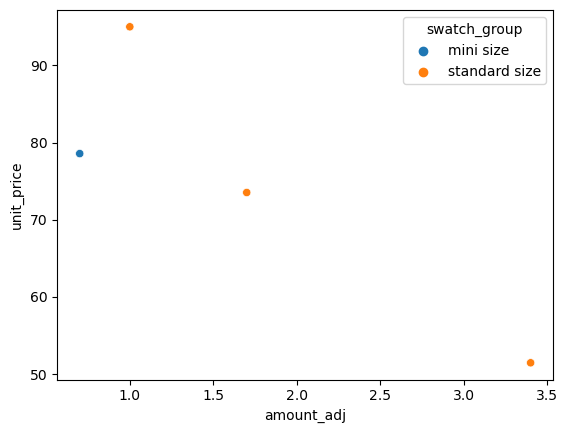

In [670]:

# dg_light_blue = df[df['product_id']==12420]

sns.scatterplot(data=df[df['product_id']==4484], x='amount_adj', y='unit_price', hue='swatch_group')


In [381]:
temp = df[df['swatch_group'].isin(['standard size','mini size'])].groupby(['product_id','swatch_group'], as_index=False)['amount_a'].nunique()
temp = temp.groupby(['product_id'], as_index=False)['amount_a'].sum()
eligible_products = temp[temp['amount_a']==2]['product_id'].unique()
target_comp_df = df[(df['product_id'].isin(eligible_products)) & (df['swatch_group'].isin(['standard size','mini size']))]
              

,product_id,swatch_group,amount_a
0,956,standard size,2
1,1272,standard size,1
2,1272,value size,1
3,1273,standard size,1
4,2855,mini size,1
...,...,...,...
6608,91627363,mini size,1
6609,91627363,standard size,1
6610,96644288,standard size,1
6611,97989778,standard size,1


## Swatch group comparisons

In [384]:
# target_comp_df = target_comp_df[target_comp_df['brand_name']=='milk makeup']
target_comp_df = target_comp_df[target_comp_df.groupby(['brand_name','product_name'])['swatch_group'].transform(lambda x : x.nunique()>1)]


target_comp_df = target_comp_df.pivot(index=['brand_name','product_name'], columns='swatch_group', values='unit_price')
target_comp_df = target_comp_df.reset_index()
target_comp_df['size_diff'] = target_comp_df['standard size'] - target_comp_df['mini size']
target_comp_df['ratio_mini_to_standard'] = target_comp_df['mini size'] / target_comp_df['standard size']

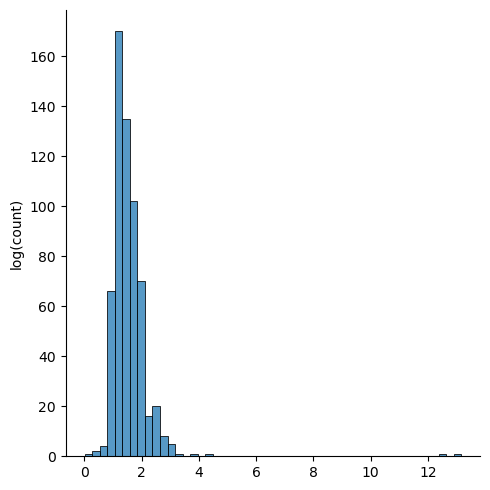

In [386]:
sns.displot(data=target_comp_df, x="ratio_mini_to_standard", bins=50)

plt.ylabel('log(count)')
plt.title('')
plt.xlabel('')
plt.tight_layout()
plt.show()

In [390]:
def filter_product_comparison_data(df, col, asc=True, lim=10):
    return df.sort_values(by=col, ascending=asc).head(lim)

# x best value mini products
# sort by mini unit price ascending, top x
# x best value standard products
# 
# sort by standard unit price ascending, top x
# x best value mini compared to standard
# target_comp_df = filter_product_comparison_data(target_comp_df, 'ratio_mini_to_standard', asc=True, lim=10)

# sort by ratio, ascending, top x
target_comp_df = filter_product_comparison_data(target_comp_df, 'ratio_mini_to_standard', asc=True, lim=10)
# x best standard compared to mini
# sort by ration, descending, top x
# target_comp_df = filter_product_comparison_data(target_comp_df, 'ratio_mini_to_standard', asc=False, lim=10)


In [510]:
target_comp_df.head(5)

swatch_group,brand_name,product_name,mini size,standard size,size_diff,ratio_mini_to_standard
399,one/size by patrick starrr,fantasize lifting & lengthening mascara,0.730769,71.739130,71.008361,0.010186
47,bumble and bumble,sunday purifying clay detox shampoo,8.500000,22.000000,13.500000,0.386364
375,nars,laguna talc-free bronzer powder,631.578947,1315.789474,684.210526,0.480000
204,hourglass,arch brow micro sculpting pencil,27500.000000,39000.000000,11500.000000,0.705128
565,tom ford,soleil blanc shimmering body oil,28.000000,38.235294,10.235294,0.732308


In [507]:
target_comp_df.set_index(['brand_name','product_name']).stack('swatch_group').reset_index().rename(columns={0:'unit_price'})


,brand_name,product_name,swatch_group,unit_price
0,one/size by patrick starrr,fantasize lifting & lengthening mascara,mini size,0.730769
1,one/size by patrick starrr,fantasize lifting & lengthening mascara,standard size,71.739130
2,one/size by patrick starrr,fantasize lifting & lengthening mascara,size_diff,71.008361
3,one/size by patrick starrr,fantasize lifting & lengthening mascara,ratio_mini_to_standard,0.010186
4,bumble and bumble,sunday purifying clay detox shampoo,mini size,8.500000
5,bumble and bumble,sunday purifying clay detox shampoo,standard size,22.000000
6,bumble and bumble,sunday purifying clay detox shampoo,size_diff,13.500000
7,bumble and bumble,sunday purifying clay detox shampoo,ratio_mini_to_standard,0.386364
8,nars,laguna talc-free bronzer powder,mini size,631.578947
9,nars,laguna talc-free bronzer powder,standard size,1315.789474


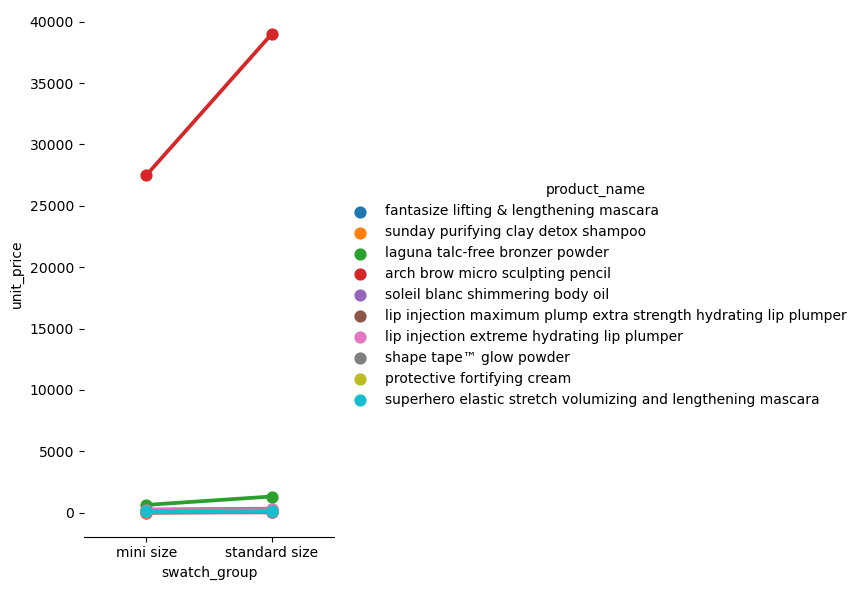

In [391]:
filtered_df = target_comp_df.set_index(['brand_name','product_name']).stack('swatch_group').reset_index().rename(columns={0:'unit_price'})

filtered_df = filtered_df[(~filtered_df['swatch_group'].isin(['size_diff','ratio_mini_to_standard']))]
                             
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=filtered_df, x="swatch_group", y="unit_price", hue="product_name",
    capsize=.2, #palette="YlGnBu_d",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

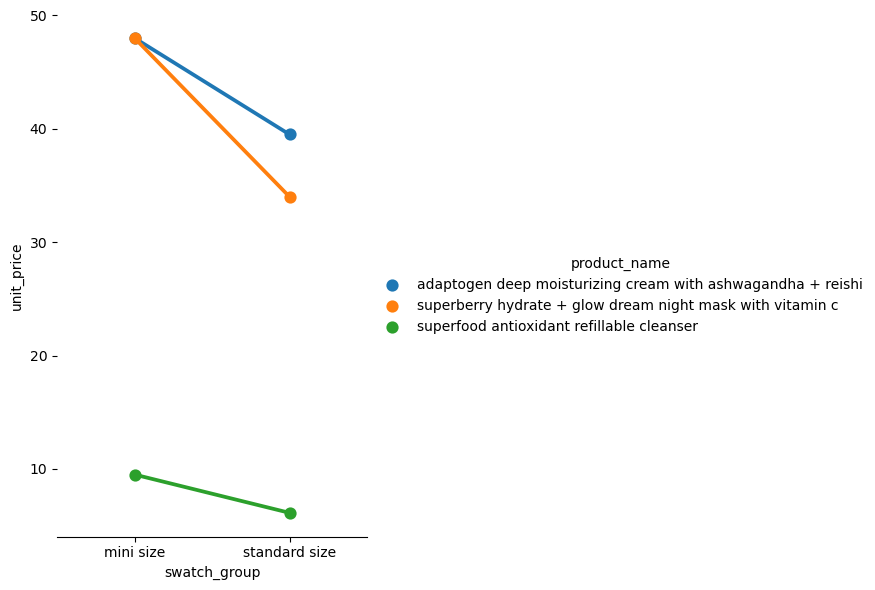

In [82]:
filtered_df = target_comp_df[(target_comp_df['swatch_group']!='size_diff') & (target_comp_df['brand_name']=='youth to the people')]
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=filtered_df, x="swatch_group", y="unit_price", hue="product_name",
    capsize=.2, #palette="YlGnBu_d",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

In [65]:
# in bare minerals - mini size == standard

In [66]:
issue_brands = ['Tom Ford', 'tarte', 'Moroccanoil', 'Dior', 'Anastasia Beverly Hills']
prods = ['clinique']
# url = 'https://www.sephora.com/ca/en/product/charlotte-tilbury-airbrush-flawless-setting-spray-P461147?skuId=2368439&icid2=products%20grid:p461147:product'

# url = 'https://www.sephora.com/ca/en/product/ambient-lighting-blush-collection-P384963?skuId=1581321&icid2=products%20grid:p384963:product'
# lots of options all same size
# url = "https://www.sephora.com/ca/en/product/saie-glowy-super-skin-lightweight-hydrobounce-serum-foundation-P504907?icid2=new_ca_skugrid_ufe:p504907:product"
# ran into issue getting product name
# url = "https://www.sephora.com/ca/en/product/book-personal-travel-spray-P501954?icid2=homepage_productlist_brandnewadditions_ca_rwd_092022"
# value set works
# url = 'https://www.sephora.com/ca/en/product/laneige-midnight-to-morning-hydration-set-P504208?skuId=2639557&icid2=products%20grid:p504208:product'
# hair brush with no ingredients
# url = 'https://www.sephora.com/ca/en/product/sephora-collection-scalp-massager-P472069?skuId=2414555&icid2=products%20grid:p472069:product'
# new prod
# url = 'https://www.sephora.com/ca/en/product/gxve-by-gwen-stefani-check-my-glow-platinum-glow-highlighter-P505655?icid2=new_ca_skugrid_ufe:p505655:product'
# sale prod
# url = 'https://www.sephora.com/ca/en/product/green-microalgae-retinol-regenerating-serum-P506077?skuId=2672301&icid2=products%20grid:p506077:product'
# no reviews yet or ratings

# broken page https://www.sephora.com/ca/en/product/beautyblender-bronze-besties-P505630?skuId=2662559&icid2=products


with open(data_dir+'brand_data.json') as file:
    brand_data = json.loads(file.read())

NameError: name 'data_dir' is not defined

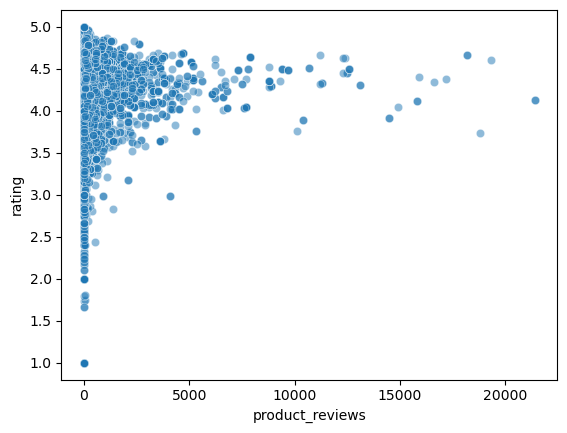

,internal_product_id,url,product_name,brand_name,options,rating,product_reviews,ingredients,n_loves,categories,swatch_group,size,name,price,sku,out_of_stock,limited_edition,new_product,few_left,sale,refill,lvl_0_cat,lvl_1_cat,lvl_2_cat,url_path,url_sku,url_params,product_multiplier,multiplier,amount_a,unit_a,amount_b,unit_b,misc_info,swatch_details,unit_price,product_id
353,144,https://www.sephora.com/ca/en/product/a-tint-o...,brownish hair powder,bumble and bumble,"[{'swatch_group': 'Standard size', 'size': Non...",3.1164,507.0,"Dimethyl Ether, Alcohol Denat., Propylene Glyc...",8500.0,"['Hair', 'Hair Styling & Treatments', 'Dry Sha...",standard size,4.4 oz 130 ml,NaN,50.0,1270388,False,False,False,False,False,False,Hair,Hair Styling & Treatments,Dry Shampoo,/ca/en/product/a-tint-of-brown-hair-powder,1270388,"{'skuId': ['1270388'], 'icid2': ['products gri...",NaN,NaN,4.400,oz,130.00,ml,NaN,standard size,11.363636,280526
1805,1215,https://www.sephora.com/ca/en/product/morphe-m...,make it big brush-tip liquid liner,morphe,"[{'swatch_group': 'Standard size', 'size': 'Si...",2.9583,24.0,"Water (Aqua, Eau), Acrylates Copolymer, Black ...",1300.0,"['Makeup', 'Eye', 'Eyeliner']",standard size,0.019 oz 0.55 ml,color: bold black,16.0,2524718,False,False,False,False,False,False,Makeup,Eye,Eyeliner,/ca/en/product/morphe-make-it-big-brush-tip-li...,2524718,"{'skuId': ['2524718'], 'icid2': ['products gri...",NaN,NaN,0.019,oz,0.55,ml,NaN,standard size,842.105263,476714


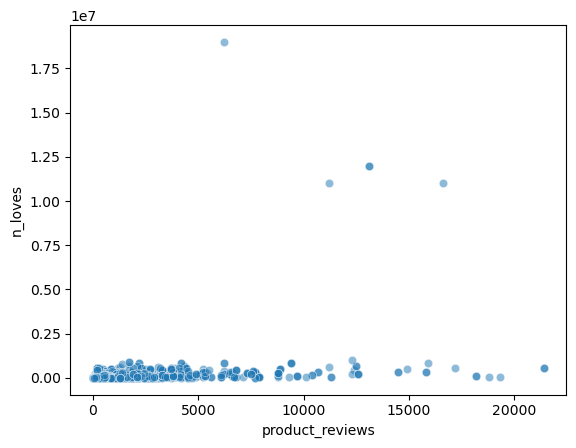

array(['cream lip stain liquid lipstick', 'radiant creamy concealer',
       'lip sleeping mask intense hydration with vitamin c',
       'soft pinch liquid blush'], dtype=object)

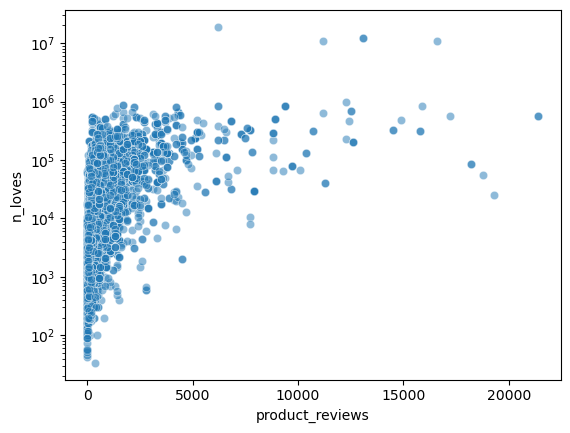

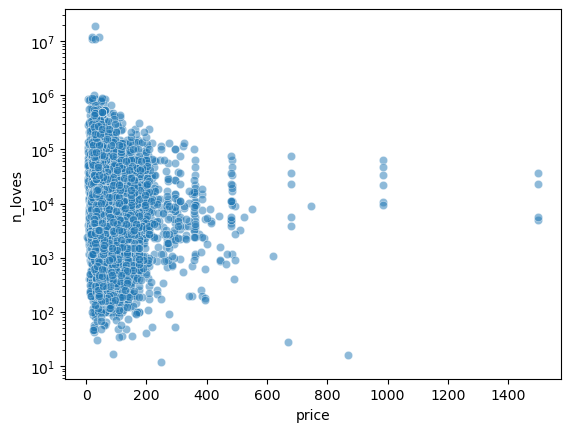

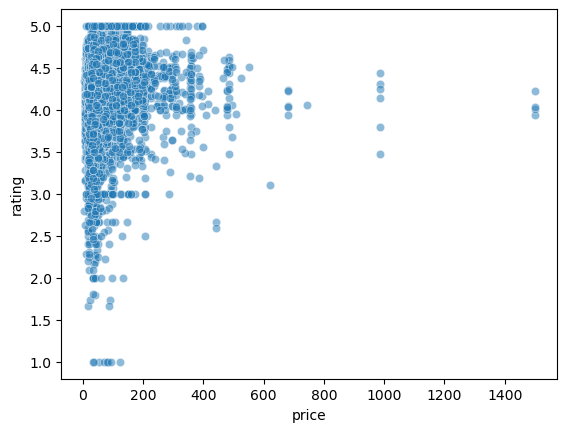

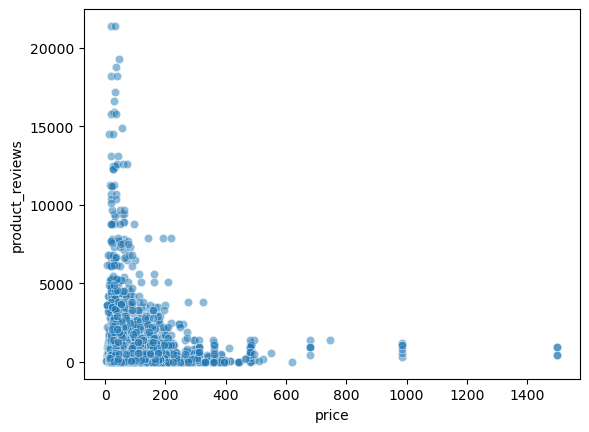

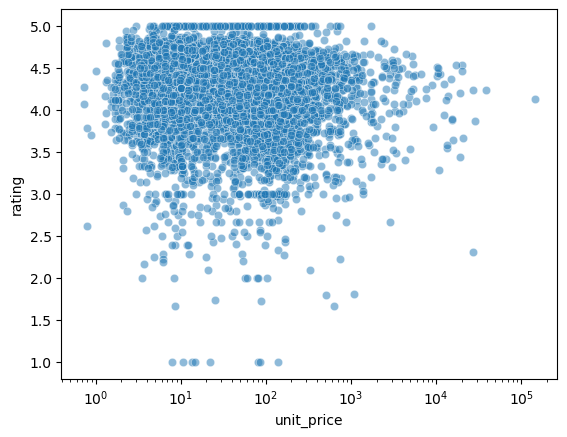

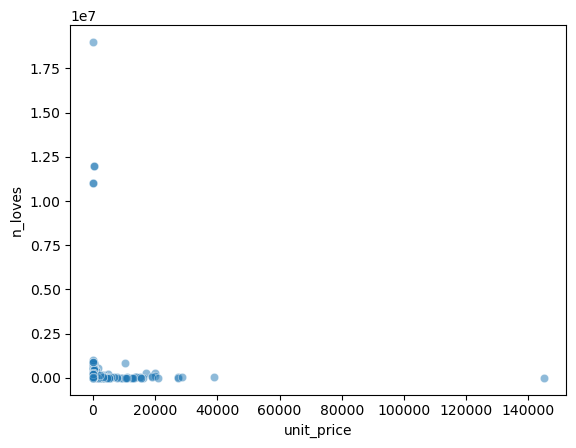

In [148]:

# df_products
# EDA - what is the distribution of product reviews
# scatter reviews v ratings

sns.scatterplot(data=df, x="product_reviews", y="rating", alpha=0.5)
plt.show()
# how many products have no reviews?
# interesting outliers - looked at reviews, truly bad
display(df_products[(df['product_reviews']>4000) & (df_products['rating']<3.2)])


# scattr review v loves
# the handful of outliers are so interesting
# was there a promotion to add these to loves list?
sns.scatterplot(data=df, x="product_reviews", y="n_loves", alpha=0.5)
plt.show()
display(df[(df['n_loves']>1500000)]['product_name'].unique())
sns.scatterplot(data=df, x="product_reviews", y="n_loves", alpha=0.5)
plt.yscale('log')
plt.show()
# scatter n loves v price 
sns.scatterplot(data=df, x="price", y="n_loves", alpha=0.5)
plt.yscale('log')
plt.show()


sns.scatterplot(data=df, x="price", y="rating", alpha=0.5)
plt.show()

sns.scatterplot(data=df, x="price", y="product_reviews", alpha=0.5)
plt.show()

sns.scatterplot(data=df[df['unit_a']=='oz'], x="unit_price", y="rating", alpha=0.5)
plt.xscale('log')
plt.show()

sns.scatterplot(data=df[df['unit_a']=='oz'], x="unit_price", y="n_loves", alpha=0.5)
plt.show()